<a href="https://colab.research.google.com/github/Hwajun1323/ML/blob/master/result/20frame/5classes/cross_validation_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install keras-metrics

In [2]:
! pip install -q scikit-plot

In [3]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.utils import plot_model

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score , cross_validate
from sklearn.model_selection import KFold, StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier

import keras_metrics as km

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [7]:
data_dir = "/content/drive/My Drive/dataset/video_data"
#data_dir = "video_data/"
img_height, img_width = 64, 64
seq_len = 20

classes = ["Child's room",  "Museum", "Office", "Restaurant","DiningRoom"]
num_classes = len(classes)
print("Number of Class: ", num_classes)

#  Creating frames from videos

def frames_extraction(video_path):
    frames_list = []

    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable
    count = 1

    while count <= seq_len:
        success, image = vidObj.read()
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
            
    return frames_list

# Create the actual data from the sequence of images

def create_data(input_dir):
    X = []
    Y = []

    classes_list = os.listdir(input_dir)

    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)

                y = [0] * len(classes)
                y[classes.index(c)] = 1
                #print(y)
                Y.append(y)

    X = np.asarray(X)
    Y = np.asarray(Y)
    
    return X, Y

Number of Class:  5


In [8]:
X, Y = create_data(data_dir)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)

DiningRoom
Child's room
Restaurant
Office
Museum


In [ ]:
print(X)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [16]:
def create_model():
    model = Sequential()

    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), return_sequences=False, data_format="channels_last", input_shape=(seq_len, img_height, img_width, 3)))
    model.add(Dropout(0.3))

    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())

    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))

    #model.summary()

    # Various optimizer

    #opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #opt = keras.optimizers.SGD(lr=0.001)
    #opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
    opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
    #opt = keras.optimizers.Adagrad(lr=0.001, epsilon=1e-6)
    #opt = keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95, epsilon=None, decay=0.0)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    return model

In [17]:
model = KerasClassifier(build_fn=create_model, epochs=80, batch_size=40, verbose=0)
kfold = KFold(n_splits=3, shuffle=True, random_state=None) 
results = cross_val_score(model, X, Y, cv=kfold)

print('Result of Cross Validation:')
print('cross validation accuracy:',np.round(results, 4))
print('mean accuracy:', np.round(np.mean(results), 4))
print('std :', np.round(np.std  (results), 4))

Result of Cross Validation:
cross validation accuracy: [0.3511 0.3196 0.3753]
mean accuracy: 0.3487
std : 0.0228


In [18]:
from sklearn.model_selection import cross_val_predict

model = KerasClassifier(build_fn=create_model, epochs=80, batch_size=40, verbose=0)
kfold = KFold(n_splits=3, shuffle=True, random_state=None) 
predicted = cross_val_predict(model, X, Y, cv=kfold)

print('Cross validation prediction done!')

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Cross validation prediction done!


In [19]:
from sklearn.metrics import precision_recall_fscore_support as score   
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rounded_Y=np.argmax(Y, axis=1)
#print(Y)
#print(rounded_Y)


# Confusion Matrix
cm = confusion_matrix(rounded_Y, predicted) 
print('Confusion matrix: \n')
print(cm)


# Classification report 
targets = ['Class0', 'Class1', 'Class2', 'Class3', 'Class4']
print('\nClassification report:\n',classification_report(rounded_Y, predicted, target_names=targets))

Confusion matrix: 

[[ 33  19   0 146   1]
 [ 22   7   0 202   1]
 [ 12   8   0 156   2]
 [ 19  19   0 376   1]
 [ 17  19   0 169  10]]

Classification report:
               precision    recall  f1-score   support

      Class0       0.32      0.17      0.22       199
      Class1       0.10      0.03      0.05       232
      Class2       0.00      0.00      0.00       178
      Class3       0.36      0.91      0.51       415
      Class4       0.67      0.05      0.09       215

    accuracy                           0.34      1239
   macro avg       0.29      0.23      0.17      1239
weighted avg       0.31      0.34      0.23      1239



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


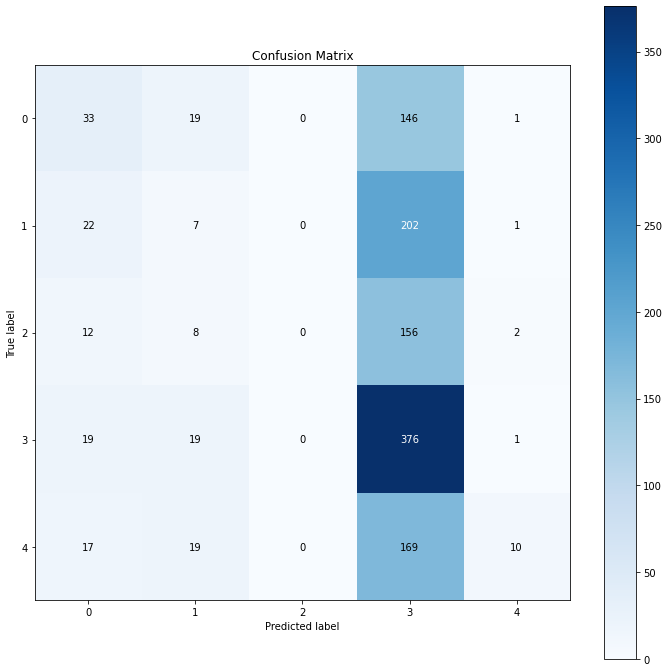

In [20]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(rounded_Y, predicted,figsize=(12,12))

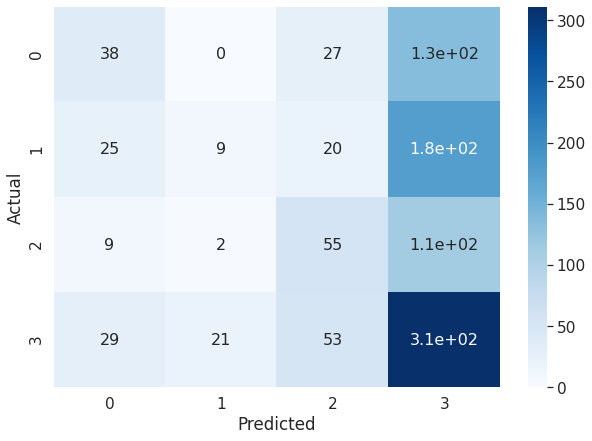

In [ ]:
import pandas as pd
import seaborn as sn

df_cm = pd.DataFrame(cm, columns=np.unique(rounded_Y), index = np.unique(rounded_Y))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})